# Predicting Energy Efficiency With Regression

In [1]:
# Please load packages before continuing:
# hit "restart and run all" every time
library(tidyverse)
library(readxl)
library(repr) # for visualization
library(tidymodels)
library(cowplot)
library(GGally)
options(repr.matrix.max.rows = 6)
set.seed(2020)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

## Introduction

**Background Information**

The heating load of a building is "the amount of heat energy" needed "to maintain the temperature in an acceptable range" (Government of Australia).
A higher heating load correlates to more heat energy required, which is detrimental to the environment, and has a higher monetary cost. In fact, an MIT study has found that "energy consumption in the buildings sector accounts for 25 to 30 percent of global carbon dioxide emissions" (Urban & Glicksman, 2006).
We aim to study how various factors such as surface area, overall height, and glazing area (ie. size of windows) affects the heating load of buildings. We define more energy-efficient buildings as buildings that require lower heating loads.

**Question**

What is the heating load (energy-efficiency) for a building with a given surface area, overall height, and glazing area?

**Dataset Description**

NEED DATASET DICTIONARY 

We're using the "Energy Efficiency Data Set" created at the University of Oxford (Xifara, Tsanas).
It contains eight attributes and two outcomes which are the column headers of the tibble below. Initially, all columns were labelled X1, X2, etc. instead of their corresponding descriptive names. The dataset has 768 rows and was generated through computer simulation. All observations (buildings) have the same volume, thus we can evaluate the effect of predictors independent of volume.

## Method

**Process**

(FROM PROPOSAL MAYBE NEED TO CHANGE)

We'll tidy the data, find summary statistics and number of rows missing data.

We'll use the variables Surface Area, Overall Height, and Glazing Area as they affect the heating load most significantly.

We won't use Relative Compactness because the dataset didn't explain what it means; the Roof Area and Wall Area because they're encompassed within Surface Area; Orientation because it’s a categorical variable, which can have too much of an impact on regression analysis and the categories ("2", "3", "4", "5") are not defined; and Glazing Area Distribution since it's similar to Glazing Area.

We'll visualize our training data using only our chosen variables to interpret their relationships with Heating Load.

We'll center and scale the data and then use both K-nearest neighbours and linear regression to see which is more accurate for our data. We'll use cross validation to find the best value of k and set the seed to ensure reproducibility. Then, visualize the results with one scatter plot for each variable (predictor on x-axis, heating load on y-axis).

We choose "heating load" because in Vancouver, we need to keep buildings warm due to cold winters.

**Reading Data Set into R and Tidying (changing column names)**

In [2]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx"
file_name <- "energy-efficiency.xlsx"
download.file(url, file_name)
energy_data <- read_excel(file_name, 
                          skip = 1, 
                          col_names = c("Relative.Compactness", "Surface.Area", "Wall.Area", 
                                        "Roof.Area", "Overall.Height", "Orientation", 
                                        "Glazing.Area", "Glazing.Area.Distribution", 
                                        "Heating.Load", "Cooling.Load"))
energy_data

Relative.Compactness,Surface.Area,Wall.Area,Roof.Area,Overall.Height,Orientation,Glazing.Area,Glazing.Area.Distribution,Heating.Load,Cooling.Load
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.98,514.5,294,110.25,7,2,0,0,15.55,21.33
0.98,514.5,294,110.25,7,3,0,0,15.55,21.33
0.98,514.5,294,110.25,7,4,0,0,15.55,21.33
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0.62,808.5,367.5,220.5,3.5,3,0.4,5,16.44,17.11
0.62,808.5,367.5,220.5,3.5,4,0.4,5,16.48,16.61
0.62,808.5,367.5,220.5,3.5,5,0.4,5,16.64,16.03


**Cleaning and Wrangling Data**

In [3]:
# Table with variables that we will be using in our analysis
energy_data_reduced <- energy_data |>
                    select(Surface.Area, Overall.Height, Glazing.Area, Heating.Load)
energy_data_reduced

Surface.Area,Overall.Height,Glazing.Area,Heating.Load
<dbl>,<dbl>,<dbl>,<dbl>
514.5,7,0,15.55
514.5,7,0,15.55
514.5,7,0,15.55
⋮,⋮,⋮,⋮
808.5,3.5,0.4,16.44
808.5,3.5,0.4,16.48
808.5,3.5,0.4,16.64


In [4]:
energy_split <- initial_split(energy_data_reduced, prop = 0.75, strata = Heating.Load)
energy_train <- training(energy_split)
energy_test <- testing(energy_split)

**Data Summarization (only training data)**

In [5]:
# Mean Table
energy_data_mean <- summarize(energy_train,
    Surface.Area.Mean = mean(Surface.Area),                   
    Overall.Height.Mean = mean(Overall.Height),                        
    Glazing.Area.Mean = mean(Glazing.Area),                            
    Heating.Load.Mean = mean(Heating.Load))
energy_data_mean

Surface.Area.Mean,Overall.Height.Mean,Glazing.Area.Mean,Heating.Load.Mean
<dbl>,<dbl>,<dbl>,<dbl>
672.5165,5.243924,0.2347222,22.3232


In [6]:
# Median Table
energy_data_median <- summarize(energy_train,
    Surface.Area.Median = median(Surface.Area),                   
    Overall.Height.Median = median(Overall.Height),                        
    Glazing.Area.Median = median(Glazing.Area),  
    Heating.Load.Median = median(Heating.Load))
energy_data_median

Surface.Area.Median,Overall.Height.Median,Glazing.Area.Median,Heating.Load.Median
<dbl>,<dbl>,<dbl>,<dbl>
686,3.5,0.25,18.95


In [7]:
# Finding Mode
heating_mode <- names(sort(-table(energy_train$Heating.Load)))[1]
surface_mode <- names(sort(-table(energy_train$Surface.Area)))[1]
height_mode <- names(sort(-table(energy_train$Overall.Height)))[1]
glazing_mode <- names(sort(-table(energy_train$Glazing.Area)))[1]

# Mode Table
energy_data_mode <- summarize(energy_train,
                        Surface.Area.Mode = surface_mode,
                        Overall.Height.Mode = height_mode,
                        Glazing.Area.Mode = glazing_mode,
                        Heating.Load.Mode = heating_mode)
energy_data_mode

Surface.Area.Mode,Overall.Height.Mode,Glazing.Area.Mode,Heating.Load.Mode
<chr>,<chr>,<chr>,<chr>
808.5,3.5,0.25,15.16


In [8]:
# Max Table
energy_data_max <- summarize(energy_train,
    Surface.Area.Max = max(Surface.Area),                   
    Overall.Height.Max = max(Overall.Height),                        
    Glazing.Area.Max = max(Glazing.Area),  
    Heating.Load.Max = max(Heating.Load))
energy_data_max

Surface.Area.Max,Overall.Height.Max,Glazing.Area.Max,Heating.Load.Max
<dbl>,<dbl>,<dbl>,<dbl>
808.5,7,0.4,42.77


In [9]:
# Min Table
energy_data_min <- summarize(energy_train,
    Surface.Area.Min = min(Surface.Area),                   
    Overall.Height.Min = min(Overall.Height),                        
    Glazing.Area.Min = min(Glazing.Area),  
    Heating.Load.Min = min(Heating.Load))
energy_data_min

Surface.Area.Min,Overall.Height.Min,Glazing.Area.Min,Heating.Load.Min
<dbl>,<dbl>,<dbl>,<dbl>
514.5,3.5,0,6.01


In [10]:
# Number of Rows Missing Data
num_rows_missing_data <- energy_train |>
                        filter(Surface.Area == NA | 
                               Overall.Height == NA | Glazing.Area == NA | Heating.Load == NA) |>
                        nrow() |>
                        as_tibble()
colnames(num_rows_missing_data) <- c("Number.Of.Rows.Missing.Data")
num_rows_missing_data

Number.Of.Rows.Missing.Data
<int>
0


**Initial Data Visualization (only training data)**

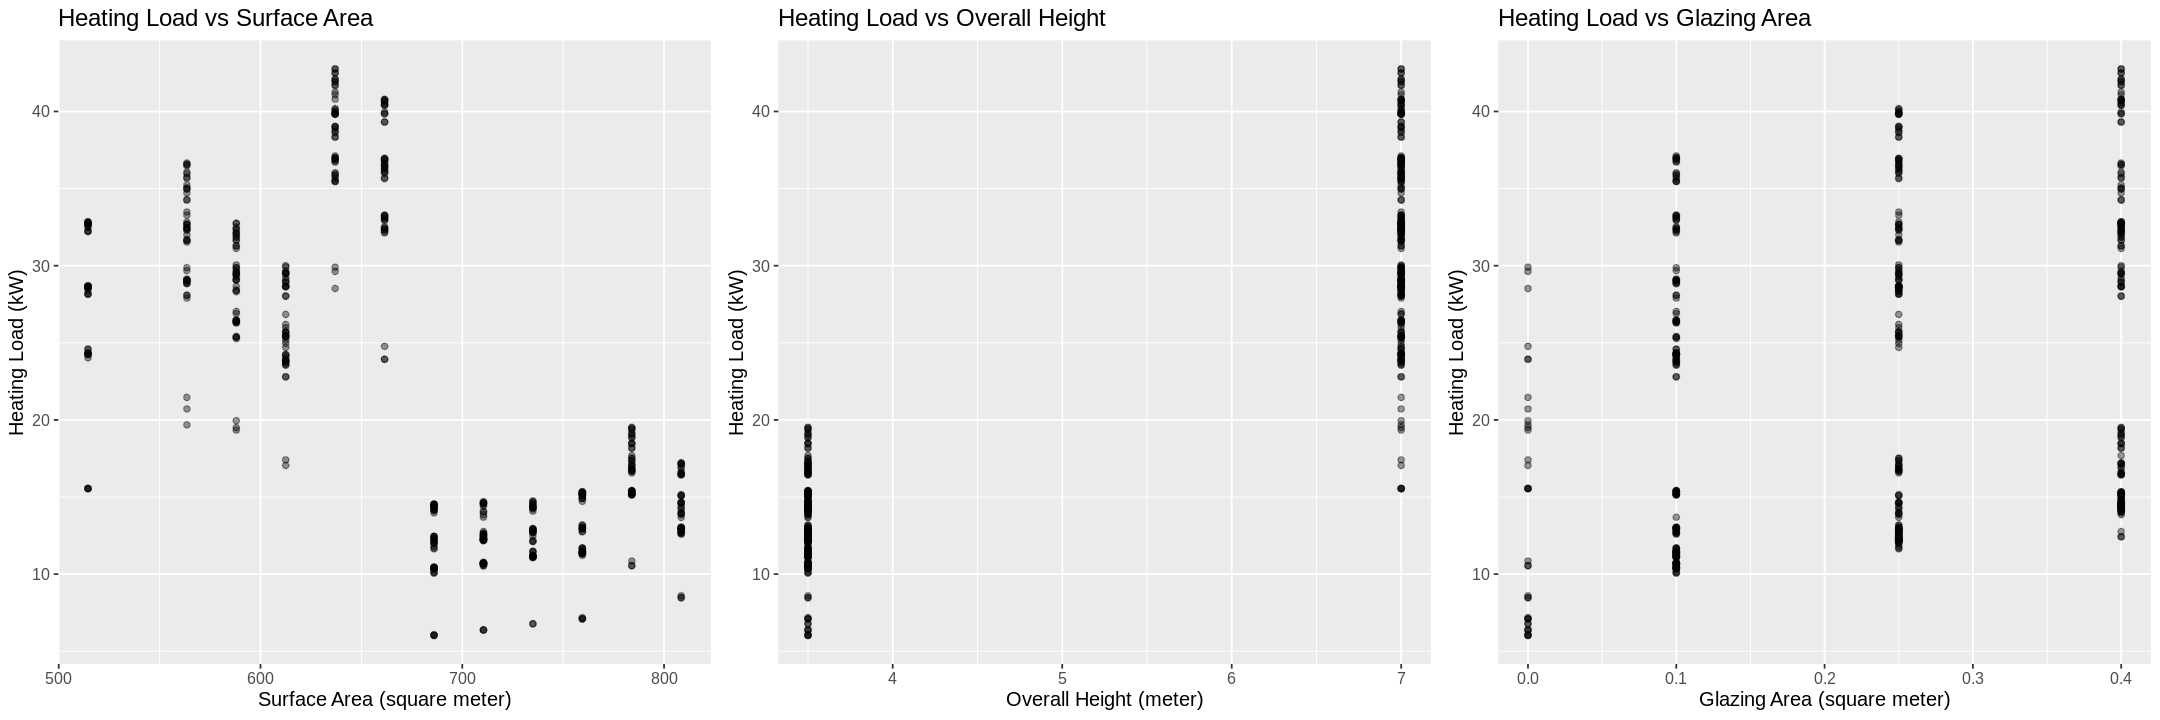

In [11]:
options(repr.plot.width=18, repr.plot.height=6)
plot_surface <- ggplot(energy_train, aes(x = Surface.Area, y = Heating.Load)) +
    geom_point(alpha = 0.4) +
    labs(x = "Surface Area (square meter)", y = "Heating Load (kW)") +
    theme(text = element_text(size = 12)) +
    ggtitle("Heating Load vs Surface Area")
plot_height <- ggplot(energy_train, aes(x = Overall.Height, y = Heating.Load)) +
    geom_point(alpha = 0.4) +
    labs(x = "Overall Height (meter)", y = "Heating Load (kW)") +
    theme(text = element_text(size = 12)) +
    ggtitle("Heating Load vs Overall Height")
plot_glazing <- ggplot(energy_train, aes(x = Glazing.Area, y = Heating.Load)) +
    geom_point(alpha = 0.4) +
    labs(x = "Glazing Area (square meter)", y = "Heating Load (kW)") +
    theme(text = element_text(size = 12)) +
    ggtitle("Heating Load vs Glazing Area")
plot_grid(plot_surface, plot_height, plot_glazing, nrow = 1)

**Interpretation of Visualizations**

Our first plot doesn’t show a continuous linear pattern. The relationship changes from negative to positive around the middle, where the Heating Load drops and starts to increase more gradually. This change may indicate a more energy-efficient Surface Area around its median, whereas considering the jumps at ~635 m^2, and ~785 m^2 (where afterwards the relationship changes direction), it could also mean that other predictor variables are having an effect on Heating Load.

For our other two plots, both Overall Height and Glazing Area have a positive linear relationship with Heating Load. Differently from Overall Height, when Glazing Area is 0 m^2, the Heating Load is distributed across a wider range, thus at 0 m^2 other predictor variables may have a greater effect on Heating Load. In most of our visualizations, the Heating Load values are widely distributed for a single predictor variable value, which could mean that other variables are having an effect.

#### Expected Outcomes

From our initial visualizations, we expect Heating Load to be proportional to Overall Height and Glazing Area, whereas the relationship between Heating Load and Surface Area is unclear for now.

## Data Analysis

#### K-NN Regression

In [12]:
# Recipe
data_recipe <- recipe(Heating.Load ~ Surface.Area + Overall.Height + Glazing.Area, 
                      data = energy_train) |>                                    
                      step_scale(all_predictors()) |> #SCALING AND CENTERING
                      step_center(all_predictors())

In [13]:
# Tuning and Performing 5 Fold Cross Validation
data_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>  #TUNING
       set_engine("kknn") |>
       set_mode("regression") 

data_vfold <- vfold_cv(energy_train, v = 5, strata = Heating.Load)

data_workflow <- workflow() |>
    add_recipe(data_recipe) |>
    add_model(data_spec)

gridvals <- tibble(neighbors = seq(from = 1, to = 100, by = 1)) #TESTING K VALUES

data_results <- data_workflow |>
  tune_grid(resamples = data_vfold, grid = gridvals) |>
  collect_metrics()

data_results_sorted <- data_results |>
    filter(.metric == "rmse") |>
    arrange(mean)

data_results_sorted

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
4,rmse,standard,0.7351523,5,0.05947831,Preprocessor1_Model004
2,rmse,standard,0.7384156,5,0.08201573,Preprocessor1_Model002
1,rmse,standard,0.7402031,5,0.06425753,Preprocessor1_Model001
⋮,⋮,⋮,⋮,⋮,⋮,⋮
60,rmse,standard,3.476701,5,0.04636760,Preprocessor1_Model060
65,rmse,standard,3.478628,5,0.04460591,Preprocessor1_Model065
64,rmse,standard,3.480080,5,0.04378572,Preprocessor1_Model064


In [14]:
# Finding Best K (Minimum RMSE)
data_min <- data_results_sorted |> 
            head(n=1)

k_min <- data_min |>
         pull(neighbors)

cat("Best K: ", k_min)

Best K:  4

In [15]:
# K-NN Regression with Best K
data_best_spec <- nearest_neighbor(weight_func = "rectangular", 
                                   neighbors = k_min) |>  #NOW WITH BEST K (MINIMUM RMSE)
          set_engine("kknn") |>
          set_mode("regression")

data_fit <- workflow() |>
          add_recipe(data_recipe) |>
          add_model(data_best_spec) |>
          fit(data = energy_train)

data_summary <- data_fit |>
           predict(energy_test) |>
           bind_cols(energy_test) |>
           metrics(truth = Heating.Load, estimate = .pred) |>
           filter(.metric == "rmse")

data_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.6320054


In [16]:
# RMSPE of K-NN Regression with Best K:

rmspe_knn <- data_summary |>
            select(.estimate) |>
            pull()
rmspe_knn

[1] 0.6320054

#### Linear Regression

In [17]:
# Recipe and Fit
lm_spec <- linear_reg() |>
    set_engine("lm") |>
    set_mode("regression")

lm_recipe <- recipe(Heating.Load ~ Surface.Area + Overall.Height + Glazing.Area, data = energy_train)
             
lm_fit <- workflow() |>
    add_recipe(lm_recipe) |>
    add_model(lm_spec) |>
    fit(data = energy_train)

lm_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
   (Intercept)    Surface.Area  Overall.Height    Glazing.Area  
     -50.77542         0.04621         7.12933        19.75534  


In [18]:
# Test Results (RMSPE)
lm_test_results <- lm_fit |>
    predict(energy_test) |>
    bind_cols(energy_test) |>
    metrics(truth = Heating.Load, estimate = .pred) |>
    filter(.metric == "rmse")

lm_test_results

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,3.129638


In [19]:
# RMSPE of Linear Regression:
rmspe_lm <- lm_test_results |>
                select(.estimate) |>
                pull()
rmspe_lm

[1] 3.129638

In [20]:
# Coefficients # do we really need this?
lm_coefficients <- lm_fit |>
                   extract_fit_parsnip() |>
                   tidy()
lm_coefficients

# Heating Load = -51.84965 + 0.04691 * (Surface Area) + 7.17125 * (Overall Height) + 21.17462 * (Glazing Area)
# (data from lm_test_results)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-50.77541765,2.609571906,-19.45737,4.276632e-65
Surface.Area,0.04620844,0.002853569,16.19321,7.974709e-49
Overall.Height,7.12933051,0.143179121,49.79309,4.153705e-210
Glazing.Area,19.75533768,0.971004706,20.34525,1.218531e-69


#### Visualizations

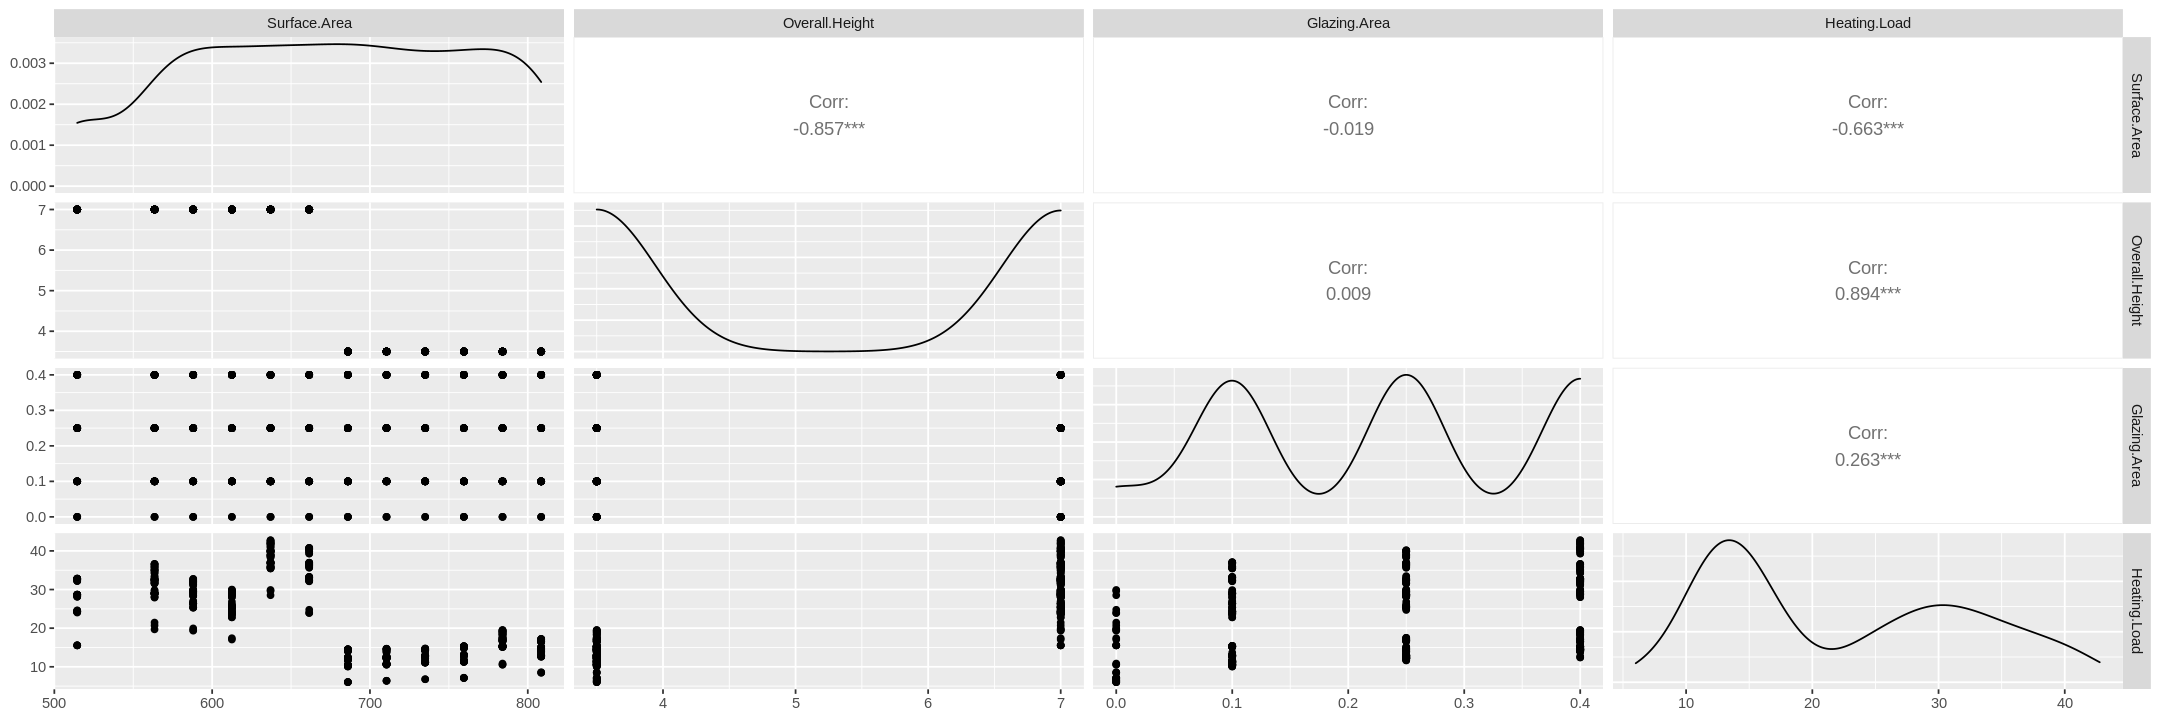

In [21]:
# Visualization
# lm_plot_final <- ggplot(energy_train, aes(x=Surface.Area ??? how to best graph out multiple variables?)
# it seems that we cannot make visualization in 2dif we are using 3 predicting variables
# rmspe of linear model is so high... only use 2 variables to do linear regression?
lm_plot <- ggpairs(energy_train)
lm_plot

## Discussion

**Comparison of K-NN vs Linear Regression**

The rmspe of k-nn regression is about 0.63, and the rmspe of linear regression is about 3.13. It is clear that k-nn regression has smaller rmspe, so k-nn regression may be the better model for this problem. The reason may be that the relationship between surface area and heating load is obviously not linear (which can be seen from the plot above), therefore linear regression is not as suitable as k-nn regression.
However, it is worth noting that the rmspe of both k-nn regression and linear regression are relatively small, which indicates that although k-nn model is better, both models have good prediction accuracy.

**Summary of Findings**

TODO (only summarize for Linear regresion or also summarize for K-NN as well)?

**Is This What we Expected?**

TODO

**What Impact Could Such Findings Have?**

(FROM PROPOSAL NEED TO CHANGE - changed)
Our findings could help architects determine the heating load of future buildings to make energy-efficient design decisions, saving cost and mitigating climate change. Further, there are currently tools such as the MIT Design Advisor that help architects design energy effecient buildings. Our findings may help the developers of such programs to fine tune their algorithms to produce even more energy effecient designs.

**What Future Questions Could This Lead to?**

(FROM PROPOSAL NEED TO CHANGE)
Does the cooling load of the building also have a similar relationship with our predictor variables?
Do external factors/variables that are not considered (e.g. climate, humidity) also affect the heating load of a building?



## Citations

Government of Australia: https://basix.nsw.gov.au/iframe/thermal-help/heating-and-cooling-loads.html#:~:text=The%20heating%20load%20is%20the,temperature%20in%20an%20acceptable%20range

Dataset (Xifara, Tsanas): https://archive.ics.uci.edu/ml/datasets/Energy+efficiency

https://basix.nsw.gov.au/iframe/thermal-help/heating-and-cooling-loads.html#:~:text=The%20heating%20load%20is%20the,temperature%20in%20an%20acceptable%20range.
https://www.plumbersstock.com/how-to-hvac/calculate-heat-load.html

MIT Design Advisor: http://designadvisor.mit.edu/design/

Urban and Glicksman: http://designadvisor.mit.edu/design/papers/urban_glicksman_simbuild_2006.pdf